# Introduction

In this document, we will present the mathematical background and experimental results for a practical concerning image classification using convolutional kernel networks based on the paper with the name "End-to-End Kernel Learning with Supervised Convolutional Kernel Networks" [[1]](#reference_1).


# Mathematical background

A convolutional kernel network constists of $K \in \mathbb{N}$ convolutional kernel layers and an output layer. The first convolutional layer recieves the input image for the network as input while the other layers recieve the output of the previous layer as input. \
In the following sections, we will look at the way the convolutional layers, the output layer and the training procedure of these layers work:

## Convolutional layer

### General case

The j-th convolutional layer recieves an image $I_{j - 1} = [y_1, \dots, y_{|\Omega_{j - 1}|}] \in \mathbb{R}^{p_{j - 1} \times |\Omega_{j - 1}|}$ ($p_{j - 1}$ being the number of input channels, $\Omega_{j - 1} \subset [0, 1]^2$ being the set of pixel coordinates) as input. \
Let $e_{j - 1} \times e_{j - 1}$ with $e_{j - 1} \in \mathbb{N}$ be the filter size of the convolutional layer and $x_y \in \mathbb{R}^{ p_{j - 1} e_{j - 1}^2 }$ be the patch of size $e_{j - 1} \times e_{j - 1}$ from the image $I$ centered around the pixel $y \in \Omega_{j - 1}$ \
The convolutional layer will then output an image $M_j = [\psi_j(x_{y_1}), \dots, \psi_j(x_{y_{|\Omega_{j - 1}|}})] \in \mathbb{R}^{p_j \times |\Omega_{j - 1}|}$ with $\psi_j: \mathbb{R}^{ p_{j - 1} e_{j - 1}^2 } \rightarrow \mathbb{R}^{p_j}$ being a function that assigns a vector $\psi_j(x_y) \in \mathbb{R}^{p_j}$ to each patch $x_y$ of the input map $I_{j - 1}$.

### Convolutional kernel layer: The function $\psi_j$
We will now define the function $\psi_j$ for a convolutional kernel layer. \
A convolutional kernel layer consists of

1. A filter matrix $Z_j = [z_1, \dots, z_{p_j}] \in \mathbb{R}^{ p_{j - 1} e_{j - 1}^2 \times p_j }$ with $z_1, \dots, z_{p_j} \in \mathbb{R}^{ p_{j - 1} e_{j - 1}^2 }$ being a selection of normed patches of size $e_{j - 1} \times e_{j - 1}$.


2. A positive-definite kernel 
$$K_j: \mathbb{R}^{ p_{j - 1} e_{j - 1}^2 } \times \mathbb{R}^{ p_{j - 1} e_{j - 1}^2 } \rightarrow \mathbb{R},~K_j(x, x') = 
\begin{cases} 
    \lVert x \rVert \lVert x' \rVert \kappa_j(\langle \frac{x}{\lVert x \rVert}, \frac{x}{\lVert x' \rVert} \rangle) & x,x' \neq 0 \\
    0 & \text{otherwise}
\end{cases} 
$$
where $\kappa_j(\langle ., . \rangle)$ is the dot-product kernel on the sphere.\
In this practical we will always use the Radial basis function (RBF) kernel with $$ 
\kappa_j(\langle x, x' \rangle) = e^{ \alpha_j(\langle x, x' \rangle - 1) } \text{ for } x, x' \in \mathbb{R}^{ p_{j - 1} e_{j - 1}^2 }, \lVert x \rVert = \lVert x' \rVert = 1 
$$
The parameter $\alpha_j > 0$ can be different from layer to layer. \
According to the Moore-Aronszajn theorem [[2]](#reference_2), the positive-definite kernel $K_j$ implicitly defines a reproducing kernel hilbert space (RKHS) $\mathcal{H}_j$ and a map $\varphi_j: \mathbb{R}^{ p_{j - 1} e_{j - 1}^2 } \rightarrow \mathcal{H}_j$ such that $\langle \varphi_j(x), \varphi_j(x') \rangle_{\mathcal{H}_j} = K_j(x, x')$.

**Short explanation / interpretation:** \
We want to project patches $\in \mathbb{R}^{ p_{j - 1} e_{j - 1}^2 }$ into a higher dimensional space.
The higher dimensional space is $\mathcal{H}_j$ and a patch $x \in \mathbb{R}^{ p_{j - 1} e_{j - 1}^2 }$ is mapped into it using the map $\varphi_j: \mathbb{R}^{ p_{j - 1} e_{j - 1}^2 } \rightarrow \mathcal{H}_j$. 
Neither $\mathcal{H}_j$ nor the map $\varphi_j$ are ever explicitly stated, but are implicitly defined through the kernel $K_j$ and the property $\langle \varphi_j(x), \varphi_j(x') \rangle_{\mathcal{H}_j} = K_j(x, x')$. 
In a sense, we explicitly state how the inner-product between two projected patches is supposed to look like through the kernel $K_j$. The space $\mathcal{H}_j$ and the map $\varphi_j$ are then defined accordingly and only exist on paper.


The patches $z_1, \dots, z_{p_j}$ together with the map $\varphi_j$ now define a subspace $\mathcal{F}_j = span\{ \varphi_j(z_1), \dots, \varphi_j(z_{p_j}) \}$. \
For each new patch $x \in \mathbb{R}^{ p_{j - 1} e_{j - 1}^2 }$ we then project $\varphi_j(x)$ into $\mathcal{F}_j$ using the orthogonal projection, resulting in 
$$f_x := proj_{ \mathcal{H}_j }(\varphi_j(x)) = \sum_{ i = 1 }^{ p_j } \alpha_i \varphi_j(z_i) \in \mathcal{H}_j \text{ with } \alpha \in \text{arg} \min_{ \alpha \in \mathbb{R}^{ p_j} } \big\lVert \sum_{ i = 1 }^{ p_j } \alpha_i \varphi_j(z_i) - \varphi_j(x) \big\rVert_{ \mathcal{H}_j }
$$
We are now looking for a parameterization $\psi_j(x) \in \mathbb{R}^{p_j}$ of $f_x$ in $\mathcal{F}_j$ such that $K(f_x, f_{x'}) = \langle f_x, f_{x'} \rangle_{ \mathcal{H}_j } = \langle \psi_j(x), \psi_j(x') \rangle$ for all patches $x, x' \in \mathbb{R}^{ p_{j - 1} e_{j - 1}^2 }$. \
After a short calculation we obtain $$
\psi_j(x) = 
\begin{cases} 
\lVert x \rVert \kappa_j(Z_j^T Z_j)^{-\frac{1}{2}} \kappa_j\big(Z_j^T \frac{x}{\lVert x \rVert}\big) & x \neq 0 \\
0 & \text{otherwise}
\end{cases}
$$
where the dot-product kernel $\kappa_j$ is applied pointwise to its arguments. A more detailed calculation can be found in appendix A of the original paper [[1]](#reference_1).

It is noteworthy that we never actually have to compute $\varphi_j(x)$. Because of property $\langle \varphi_j(x), \varphi_j(x') \rangle_{\mathcal{H}_j} = K_j(x, x')$ we can directly compute the parameterization $\psi_j(x)$ using the kernel function. For this reason this approach is called the kernel trick.

### Convolutional kernel layer: Formula for $M_j$
We will now use the formula for $\psi_j$ to obtain a fromula for $M_j = [\psi_j(x_{y_1}), \dots, \psi_j(x_{y_{|\Omega_{j - 1}|}})]$. \
For simplicity we will first assume $x_{y_1}, \dots, x_{y_{|\Omega_{j - 1}|}} \neq 0$ \
We define
1. $A_j := \kappa_j(Z_j^T Z_j)^{-\frac{1}{2}}$ to make the formula shorter
2. A linear operator $E_j$ that extracts all $e_{j-1} \times e_{j-1}$ patches from the input image, meaning $E_j(I_{j-1}) = [x_{y_1}, \dots, x_{y_{|\Omega_{j - 1}|}}]$
3. A diagonal matrix 
$$S_j =
\begin{bmatrix}
\lVert x_{y_1} \rVert & & \\
& \ddots & \\
& & \lVert x_{y_{|\Omega_{j - 1}|}} \rVert
\end{bmatrix},~
(S_j)_{km} = 
\begin{cases} 
\lVert x_{y_k} \rVert & k = m \\
0 & k \neq m
\end{cases}
$$
with the norms of the patches $x_{y_1}, \dots, x_{y_{|\Omega_{j - 1}|}}$ in the diagonal entries. \
Hence $E_j(I_{j-1})S_j^{-1} = \big[\frac{x_{y_1}}{\lVert x_{y_1} \rVert}, \dots, \frac{x_{y_{|\Omega_{j - 1}|}}}{\lVert x_{y_{|\Omega_{j - 1}|}} \rVert} \big]$

Thus using the formula 
$$\psi_j(x) = \lVert x \rVert \kappa_j(Z_j^T Z_j)^{-\frac{1}{2}} \kappa_j\big(Z_j^T \frac{x}{\lVert x \rVert}\big)$$
from above we get $$
M_j = [\psi_j(x_{y_1}), \dots, \psi_j(x_{y_{|\Omega_{j - 1}|}})] = A_j \kappa_j(Z_j^T E_j(I_{j-1}) S_j^{-1})S_j$$

In practise we add 0.00001 to the diagonal-elements of the matrix $S_j$ and define $A_j := (\kappa_j(Z_j^T Z_j) + 0.001 \mathbb{1})^{-\frac{1}{2}}$ to ensure that $S_j$ and $A_j$ are regular.

### Linear Pooling
After computing $M_j$ we can use linear pooling to reduce the resolution and gain invariance to small shifts: \
Let $\Omega_j \subset [0, 1]^2$ be the new (smaller) set of pixel coordinates after pooling and let $P_j \in \mathbb{R}^{ |\Omega_{j - 1}| \times |\Omega_j| }$ be the pooling matrix. \
Then the final output of the layer is $I_j = M_j P_j \in \mathbb{R}^{ p_j \times |\Omega_j| }$. \
If we do not wish to use pooling, we can simply set $\Omega_{j} := \Omega_{j - 1}$ and $P_j := \mathbb{1}_{|\Omega_{j}|}$ and get $I_j = M_j P_j = M_j$ 

## Output Layer
Let the network have $K \in \mathbb{N}$ convolutional layers and let the output layer have $N \in \mathbb{N}$ output nodes. \
The output layer then consists of $N$ matrices $W^{(1)}, \dots, W^{(N)} \in \mathbb{R}^{p_K \times |\Omega_K|}$ and the output of the network is 
$$O = \left(
\begin{array}{c}
\langle I_K, W^{(1)} \rangle \\ 
\vdots \\ 
\langle I_K, W^{(N)} \rangle 
\end{array} 
\right) \in \mathbb{R}^N$$
where $\langle \cdot, \cdot \rangle$ is the inner product. \
Here we differ from the paper a little bit. The original paper only presents the case $N=1$ while we look at the general case $N \geq 1$. All calculations that get affected by this change will be presented in more detail (see [appendix A](#appendix_a) and [appendix B](#appendix_b)).

## Backpropagation
Let a training set be given by a set of images $I_0^1, \dots, I_0^M$ and corresponding labels $y_1, \dots, y_M \in \mathbb{R}^N$. \
Let $L: \mathbb{R}^N \times \mathbb{R}^N \rightarrow \mathbb{R}$ be a smooth loss function that gives an error $L(y_i, O^i) \in \mathbb{R}$ of the network output $O^i$ for the input image $I_0^i$ given the true label $y_i$. Let $\lambda$ be the regularisation parameter. We train the network by minimizing
$$\tilde{L}(\mathcal{Z}, \mathcal{W}) := \frac{1}{M} \sum_{i = 1}^M L(y_i, O^i) + \frac{\lambda}{2} \sum_{i = 1}^{N} \lVert W^{(i)} \rVert_F^2 \quad \left(\lVert \cdot \rVert_F \text{ Frobenius norm} \right)$$
with respect to the filters $\mathcal{Z} = \{Z_1, \dots, Z_K\}$ and the weights $\mathcal{W} = \{W^{(1)}, \dots, W^{(N)}\}$ by using the stochastic gradient descent method:
We will pick a learning rate $\alpha > 0$ and repeatedly

1. Compute the gradients $\nabla_{W^{(k)}} \tilde{L}(\mathcal{Z}, \mathcal{W})$ for $k=1, \dots, N$ and $\nabla_{Z_j} \tilde{L}(\mathcal{Z}, \mathcal{W})$ for $j=1, \dots, K$

2. Calculate $\tilde{Z}_j = [\tilde{z}_1, \dots, \tilde{z}_{p_j}] := Z_j - \alpha \nabla_{Z_j} \tilde{L}(\mathcal{Z}, \mathcal{W})$ and set $Z_j \leftarrow \left[\frac{\tilde{z}_1}{\lVert \tilde{z}_1 \rVert}, \dots, \frac{\tilde{z}_{p_j}}{\lVert \tilde{z}_{p_j} \rVert} \right]$ for $j=1, \dots, K$

3. Set $W^{(k)} \leftarrow W^{(k)} - \alpha \nabla_{W^{(k)}} \tilde{L}(\mathcal{Z}, \mathcal{W})$ for $k=1, \dots, N$

until a termination condition is reached (e.g. stop after 100 epochs). The learning rate $\alpha$ can change from epoch to epoch. \
In the following sections we will deal with computing $\nabla_{W^{(k)}} \tilde{L}(\mathcal{Z}, \mathcal{W})$ and $\nabla_{Z_j} \tilde{L}(y_k, O^k)$

### Gradient with respect to the output weights
Let $L^{(k)}(y, o) := \frac{\partial}{\partial o_k} L(y, o)$ be the partial derivative of L with respect to the k-th component of the vector $o$.\
Then the gradient of $\tilde{L}$ with respect to $W^{(k)}~(k=1, \dots, N)$  is given by
$$\nabla_{W^{(k)}} \tilde{L}(\mathcal{Z}, \mathcal{W}) = \left( \frac{1}{M} \sum_{l = 1}^M L^{(k)}(y_l, O^l) \right) I_K^l + \lambda W^{(k)}$$
A proof can be found in [appendix A](#appendix_a).

### Gradient with respect to the filters
Let $I_0^1, \dots, I_0^M$ be training images with the true labels $y_1, \dots, y_M$ and the respective network outputs $O^1, \dots, O^M$. \
After a short calculation using Lemma 1 and Proposition 1 of the paper [[1]](#reference_1) (see [appendix B](#appendix_b)) we obtain
$$\nabla_{Z_j} L(y_k, O^k) = g_j^{(k)}\left(h_{j + 1}^{(k)}\left(\dots h_K^{(k)}\left(\sum_{i = 1}^{N} L^{(i)}(y, O^k) W^{(i)}\right)\right)\right)
$$
where $g_j^{(k)}, h_j^{(k)}$ are linear functions for the input image $I_0^k$ given by
\begin{align*}
g_j^{(k)}(U) &= E_j\left(I_{j-1}^{(k)}\right) \left(B_j^{(k)}\right)^T - \frac{1}{2} Z_j \left(\kappa_j'\left(Z_j^T Z_j\right) \odot \left(\left(C_j^{(k)}\right)^T + C_j^{(k)} \right) \right)   \\
h_j^{(k)}(U) &= E_j^*\left(Z_j B_j^{(k)} + E_j\left(I_{j-1}^{(k)}\right) \left(\left(S_j^{(k)}\right)^{-2}  \odot \left(\left(M_j^{(k)}\right)^T U P_j^T - E_j\left(I_{j-1}^{(k)}\right)^T Z_j B_j^{(k)}\right)\right)\right)
\end{align*}
with
\begin{align*}B_j^{(k)} &= \kappa_j'\left(Z_j^T E_j\left(I_{j-1}^{(k)}\right) \left(S_j^{(k)}\right)^{-1}\right) \odot \left(A_j U P_j^T\right) 
\quad \text{and} \\
C_j^{(k)} &= A_j^{\frac{1}{2}} I_j^{(k)} U^T A_j^{\frac{3}{2}}
\end{align*}

Hence 
\begin{align*}
\nabla_{Z_j} \tilde{L}(\mathcal{Z}, \mathcal{W}) 
&= \nabla_{Z_j} \left(\frac{1}{M} \sum_{k = 1}^M L(y_k, O^k) + \frac{\lambda}{2} \sum_{i = 1}^{N} \lVert W^{(i)} \rVert_F^2 \right) \\
&= \frac{1}{M} \sum_{k = 1}^M g_j^{(k)}\left(h_{j + 1}^{(k)}\left(\dots h_K^{(k)}\left(\sum_{i = 1}^{N} L^{(i)}(y_k, O^k) W^{(i)}\right)\right)\right)
\end{align*}

# Experiments
In this section we will present the experiments conducted with a convolutional kernel network (implemented in python) on the MNIST dataset (28 x 28 images with 10 classes). \
The following different network-architectures were tested, each of them with 30 filters in total:


1. A network with 3 convolutional layers, 10 filters each and filter-size 3 x 3 (with zero-padding). After the first and second layer we used average pooling with pooling-size 3 x 3:


\begin{align*}
1 \times 28 \times 28 
&\xrightarrow[10 ~ 3 \times 3 \text{ filters}]{\text{convolution (zp)}} 10 \times 28 \times 28 
&\xrightarrow[3 \times 3]{\text{avg. pooling}} 10 \times 9 \times 9 \\
&\xrightarrow[10 ~ 3 \times 3 \text{ filters}]{\text{convolution (zp)}} 10 \times 9 \times 9 
&\xrightarrow[3 \times 3]{\text{avg. pooling}} 10 \times 3 \times 3 \\ 
&\xrightarrow[10 ~ 3 \times 3 \text{ filters}]{\text{convolution (zp)}} 10 \times 3 \times 3
\end{align*}


2. A network with 3 convolutional layers, 10 filters each and filter-size 5 x 5 (with zero-padding). After the first and second layer we used average pooling with pooling-size 3 x 3:


\begin{align*}
1 \times 28 \times 28 
&\xrightarrow[10 ~ 5 \times 5 \text{ filters}]{\text{convolution (zp)}} 10 \times 28 \times 28 
&\xrightarrow[3 \times 3]{\text{avg. pooling}} 10 \times 9 \times 9 \\
&\xrightarrow[10 ~ 5 \times 5 \text{ filters}]{\text{convolution (zp)}} 10 \times 9 \times 9 
&\xrightarrow[3 \times 3]{\text{avg. pooling}} 10 \times 3 \times 3 \\
&\xrightarrow[10 ~ 5 \times 5 \text{ filters}]{\text{convolution (zp)}} 10 \times 3 \times 3
\end{align*}


3. A network with 5 convolutional layers, 5 filters each, filters 1, 3, 5 with filter-size 3 x 3 and filters 2, 4 with filter-size 1 x 1 (with zero-padding). After the first and third layer we used average pooling with pooling-size 3 x 3:


\begin{align*}
1 \times 28 \times 28 
&\xrightarrow[5 ~ 3 \times 3 \text{ filters}]{\text{convolution (zp)}} 5 \times 28 \times 28 
&\xrightarrow[3 \times 3]{\text{avg. pooling}} 5 \times 9 \times 9 
&\xrightarrow[5 ~ 1 \times 1 \text{ filters}]{\text{convolution (zp)}} 5 \times 9 \times 9 \\
&\xrightarrow[5 ~ 3 \times 3 \text{ filters}]{\text{convolution (zp)}} 5 \times 9 \times 9
&\xrightarrow[3 \times 3]{\text{avg. pooling}} 5 \times 3 \times 3
&\xrightarrow[5 ~ 1 \times 1 \text{ filters}]{\text{convolution (zp)}} 5 \times 3 \times 3 \\
&\xrightarrow[5 ~ 3 \times 3 \text{ filters}]{\text{convolution (zp)}} 5 \times 3 \times 3
\end{align*}


4. A network with 2 convolutional layers, 15 filters each and filter-size 3 x 3 (no zero-padding). After the first layer we used average pooling with pooling-size 3 x 3:


\begin{align*}
1 \times 28 \times 28 
&\xrightarrow[10 ~ 3 \times 3 \text{ filters}]{\text{convolution}} 10 \times 26 \times 26 
&\xrightarrow[3 \times 3]{\text{avg. pooling}} 10 \times 8 \times 8 \\
&\xrightarrow[10 ~ 3 \times 3 \text{ filters}]{\text{convolution}} 10 \times 6 \times 6
\end{align*}

All networks use the RBF kernel $\kappa_j(\langle x, x' \rangle) = e^{ \alpha_j(\langle x, x' \rangle - 1) }$ with $\alpha_j = 4$ for all layers $j$

The following parameters for the training algorithm were choosen:

* Initial learning rate $\alpha = 2$ (gets halved every time the loss increases in an epoch)

* Regularisation parameter $\lambda = 1/60000$

We will now look at the results achieved by the networks. To do that we first have to load the MNIST-Dataset and the trained networks together with information about the training process:

In [1]:
%matplotlib inline

import sys, os
analyses_dir = os.path.join(os.getcwd(), "analyses")
sys.path.append("src")

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mnist import MNIST
from IPython.display import HTML, display
from analysis import Analysis

mnist = MNIST('mnist')
num_epochs = 20

training_analyses = {
    '3 layers|10 3x3|zpad; 3x3 pool':
        Analysis.load_from_file(os.path.join(analyses_dir, "ana_3_3x3_layers_10_filters_3x3_pooling"), 
                      mnist.train_images, mnist.train_labels, mnist.test_images, mnist.test_labels),
    
    '3 layers|10 5x5|zpad; 3x3 pool':
        Analysis.load_from_file(os.path.join(analyses_dir, "ana_3_5x5_layers_10_filters_3x3_pooling"), 
                      mnist.train_images, mnist.train_labels, mnist.test_images, mnist.test_labels),
    
    '5 layers|3x3 & 1x1|zpad; 3x3 pool':
        Analysis.load_from_file(os.path.join(analyses_dir, "ana_3_3x3_2_1x1_layers_5_filters__3x3_pooling__zp"), 
                      mnist.train_images, mnist.train_labels, mnist.test_images, mnist.test_labels),
    
    '2 layers|15 3x3|no zpad; 3x3 pool':
        Analysis.load_from_file(os.path.join(analyses_dir, "ana_2_3x3_layers_15_filters__3x3_pooling__no_zp"), 
                      mnist.train_images, mnist.train_labels, mnist.test_images, mnist.test_labels)
    
}

## Test accuracies
The the test accuracies across the first 20 epochs were as follows:

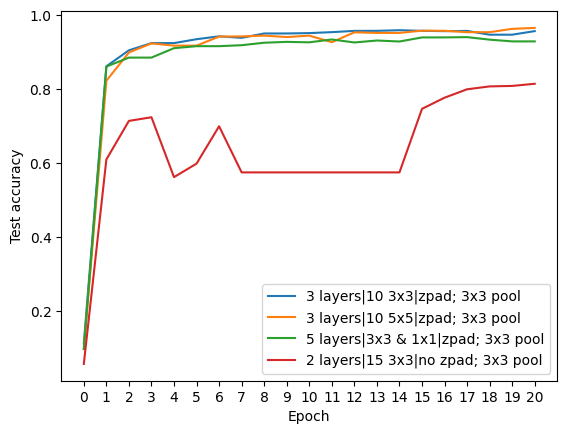

In [2]:
for network_name, ana in training_analyses.items():
    plt.plot([ana.test_results_epoch[i].correct_portion for i in range(num_epochs + 1)], label=network_name)
    
plt.xlabel('Epoch')
plt.ylabel('Test accuracy')
plt.xticks(range(num_epochs + 1))
plt.legend(loc="lower right")

plt.show()

In table format:

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 85)

epochs = {epoch: [] for epoch in range(num_epochs + 1)}
index = []
for network_name, ana in training_analyses.items():
    index.append(network_name)
    for epoch in range(num_epochs + 1):
        epochs[epoch].append(f"{int(ana.test_results_epoch[epoch].correct_portion * 100 + 0.5)}%")
        
df = pd.DataFrame(epochs)
df.index = index

print(df)

                                    0    1    2    3    4    5    6    7    8   \
3 layers|10 3x3|zpad; 3x3 pool     11%  86%  91%  92%  92%  94%  94%  94%  95%   
3 layers|10 5x5|zpad; 3x3 pool     10%  82%  90%  92%  92%  92%  94%  94%  94%   
5 layers|3x3 & 1x1|zpad; 3x3 pool  10%  86%  89%  89%  91%  92%  92%  92%  93%   
2 layers|15 3x3|no zpad; 3x3 pool   6%  61%  71%  72%  56%  60%  70%  58%  58%   

                                    9    10   11   12   13   14   15   16   17  \
3 layers|10 3x3|zpad; 3x3 pool     95%  95%  95%  96%  96%  96%  96%  96%  96%   
3 layers|10 5x5|zpad; 3x3 pool     94%  94%  93%  95%  95%  95%  96%  96%  95%   
5 layers|3x3 & 1x1|zpad; 3x3 pool  93%  93%  93%  93%  93%  93%  94%  94%  94%   
2 layers|15 3x3|no zpad; 3x3 pool  58%  58%  58%  58%  58%  58%  75%  78%  80%   

                                    18   19   20  
3 layers|10 3x3|zpad; 3x3 pool     95%  95%  96%  
3 layers|10 5x5|zpad; 3x3 pool     95%  96%  97%  
5 layers|3x3 & 1x1|zpad; 

As we can see, the first and second network performed the best and achieved a test accuracy of 96% / 97% after 20 epochs. \
Inserting convolutional layers with 1x1 filters after pooling while using less filters per layer (third network) produced worse results then the original first network (probably due to the small amount of filters per layer).\
The last network with only two layers but 15 filters for each one performed the worst.

In the following sections, we will solely focus on the best performing network:

In [4]:
best_network_name = '3 layers|10 5x5|zpad; 3x3 pool'
best_network_training_ana = training_analyses[best_network_name]

## Average Loss
The average loss across the 20 epochs was as follows:

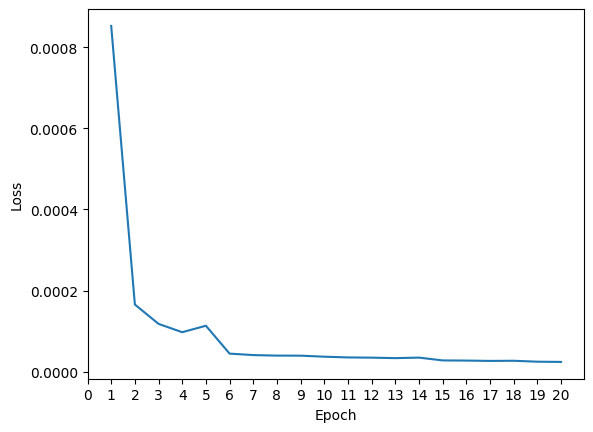

In [5]:
plt.plot(range(1, num_epochs + 1), [best_network_training_ana.trainer.average_loss_epoch[i] for i in range(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(num_epochs + 1))

plt.show()

In table format:

In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 85)

epochs = {epoch: [] for epoch in range(1, num_epochs + 1)}
index = ["Avg. Loss (per thousand)"]
for epoch in range(1, num_epochs + 1):
    epochs[epoch].append(f"{best_network_training_ana.trainer.average_loss_epoch[epoch - 1]*1000:.3f}")
        
df = pd.DataFrame(epochs)
df.index = index

print(df)

                             1      2      3      4      5      6      7      8   \
Avg. Loss (per thousand)  0.852  0.165  0.118  0.097  0.113  0.044  0.041  0.039   

                             9      10     11     12     13     14     15     16  \
Avg. Loss (per thousand)  0.039  0.037  0.035  0.034  0.033  0.035  0.028  0.027   

                             17     18     19     20  
Avg. Loss (per thousand)  0.026  0.027  0.024  0.024  


As we can see, the loss deceases drasticly within the first few epochs and than improves a lot slower (as expected). However, we still see improvements even in the later epochs. It is possible that the network would still have improved further during additional training.


## Error rate of specific numbers
We now take a look at the ratio of misclassifications of each number as shown in the diagram below:

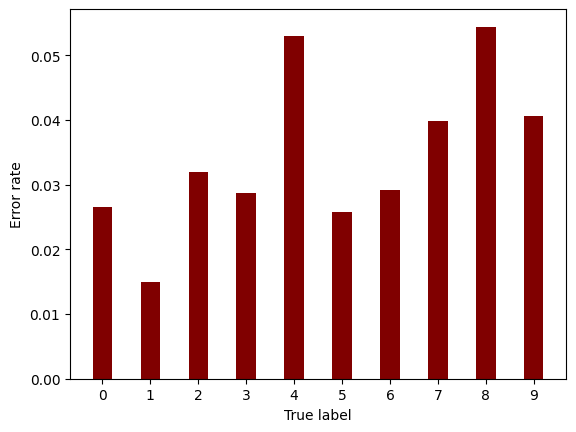

In [7]:
error_rates = best_network_training_ana.test_results_epoch[-1].label_false_portion

plt.bar(range(10), error_rates, color ='maroon',
        width = 0.4)
    
plt.xlabel('True label')
plt.ylabel('Error rate')
plt.xticks(range(10))

plt.show()

As we can see, the network has the most problems with identifying the numbers 4 and 8. We will take a closer look on the number 4:

The number 4 gets mostly misidentified as the number 9 as the diagramm below shows:

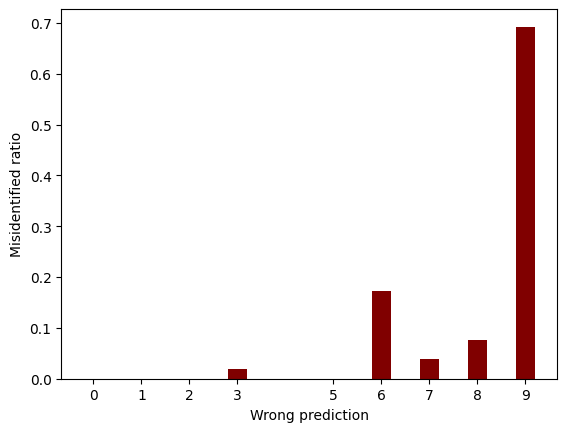

In [8]:
label_to_test = 4

network_pred = best_network_training_ana.test_results_epoch[-1].network_pred
not_label_to_test = np.arange(10)[np.arange(10) != label_to_test]
misidentified = network_pred[label_to_test][not_label_to_test]
misidentified_ratio = misidentified / misidentified.sum()

plt.bar(not_label_to_test, misidentified_ratio, color ='maroon',
        width = 0.4)
    
plt.xlabel('Wrong prediction')
plt.ylabel('Misidentified ratio')
plt.xticks(not_label_to_test)

plt.show()

Looking through the pictures of 4s that were falsely identified as the number 9, it seems that the network tends to misinterpret the upper part of 4s as the loop of the number 9, especially if the top of the 4 is closed or almost closed. The picture shown below is a good exmple of this:

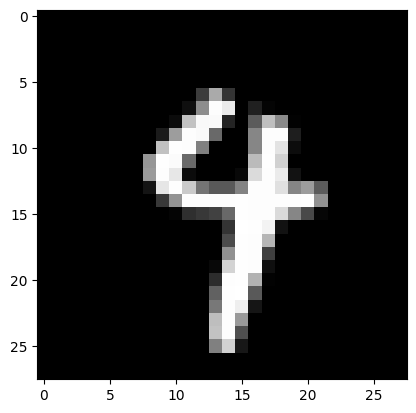

In [9]:
label_to_test = 4
network_prediction = 9

images = []

for i in range(len(mnist.test_images)):
    if mnist.test_labels[i] == label_to_test:
        x = best_network_training_ana.trainer.best_network.forward(mnist.test_images[i])
        if network_prediction == np.argmax(x):
            images.append(mnist.test_images[i])
            
plt.imshow(images[7].reshape(28, 28), cmap='gray')
plt.show()

# Appendix A: Calculation of the gradient of the loss function with respect to the weights <a id="appendix_a"></a>
Let $i \in \{ 1, \dots, p_K \},~j \in \{ 1, \dots, |\Omega_K| \},~k \in \{ 1, \dots, N \}$. \
Then $\forall l = 1, \dots, M:$
\begin{align*}
\frac{\partial}{\partial W_{ij}^{(k)}} \langle I_K^l, W^{(k)} \rangle 
&=
\frac{\partial}{\partial W_{ij}^{(k)}} \sum_{n = 1}^{p_K} \sum_{m = 1}^{|\Omega_K|}~(I_K^l)_{nm} W_{nm}^{(k)} \\
&=
(I_K^l)_{ij}
\end{align*}

Hence $\forall l = 1, \dots, M:$
\begin{align*}
\frac{\partial}{\partial W_{ij}^{(k)}} L(y_l, O^l)
&= 
\frac{\partial}{\partial W_{ij}^{(k)}} L(y_l, \left( \begin{array}{c} \langle I_K^l, W^{(1)} \rangle \\ \vdots \\ \langle I_K^l, W^{(N)} \rangle \end{array} \right)) \\
&=
\left( \frac{\partial}{\partial W_{ij}^{(k)}} \langle I_K^l, W^{(k)} \rangle \right) L^{(k)}(y_l, \left( \begin{array}{c} \langle I_K^l, W^{(1)} \rangle \\ \vdots \\ \langle I_K^l, W^{(N)} \rangle \end{array} \right)) \\
&=
(I_K^l)_{ij} L^{(k)}(y_l, O^l)
\end{align*}

We also have
\begin{align*}
\frac{\partial}{\partial W_{ij}^{(k)}} \lVert W^{(k)} \rVert_F^2
&=
\frac{\partial}{\partial W_{ij}^{(k)}} \sum_{n = 1}^{p_K} \sum_{m = 1}^{|\Omega_K|}~(W_{nm}^{(r)})^2 \\
&=
2 W_{ij}^{(k)}
\end{align*}

Bringing both together we get
\begin{align*}
\frac{\partial}{\partial W_{ij}^{(k)}} \tilde{L}(\mathcal{Z}, \mathcal{W})
&=
\frac{\partial}{\partial W_{ij}^{(k)}} \left( \frac{1}{M} \sum_{l = 1}^M L(y_l, O^l) + \frac{\lambda}{2} \sum_{r = 1}^{N} \lVert W^{(r)} \rVert_F^2 \right) \\
&=
(I_K^l)_{ij} \frac{1}{M} \sum_{l = 1}^M L^{(k)}(y_l, O^l) + \lambda W_{ij}^{(k)}
\end{align*}

Therefore
\begin{align*}
\nabla_{W^{(k)}} \tilde{L}(\mathcal{Z}, \mathcal{W}) = \left( \frac{1}{M} \sum_{l = 1}^M L^{(k)}(y_l, O^l) \right) I_K^l + \lambda W^{(k)}
\end{align*}

# Appendix B: Calculation of the gradient of the loss function with respect to the filters <a id="appendix_b"></a>
For a training image $I_0$ with the true label $y$ let $I_j^{\mathcal{Z}}$ be the output of the j-th convolutional layer given the filter matrices $\mathcal{Z} = \{ Z_1, \dots, Z_K \}$. \
Let $\varepsilon_i \in \mathbb{R}^{p_i \times |\Omega_i|},~(i \in \{ 1, \dots, K \}),~\mathcal{E} = \{ \varepsilon_1, \dots, \varepsilon_K \}$ be a pertubation of $\mathcal{Z}$ and $\mathcal{Z} + \mathcal{E} = \{ Z_1 + \varepsilon_1, \dots, Z_K + \varepsilon_K \}$. \
Lemma 1 and Proposition 1 of the paper [[1]](#reference_1) then state that there are linear functions $g_j, h_j~(j \in \{ 1, \dots, K \})$ and a matrix $\Delta I_j^{\mathcal{Z}, \mathcal{E}}$ such that 
$$I_j^{\mathcal{Z} + \mathcal{E}} = I_j^{\mathcal{Z}} +\Delta I_j^{\mathcal{Z}, \mathcal{E}} + o(\lVert \mathcal{E} \rVert) \text{ and } 
\langle \Delta I_j^{\mathcal{Z}, \mathcal{E}}, U \rangle = \langle \varepsilon_j, g_j(U) \rangle + \langle \Delta I_{j - 1}^{\mathcal{Z}, \mathcal{E}}, h_j(U) \rangle$$
where $\lVert \mathcal{E} \rVert = \sum_{i = 1}^K \lVert \varepsilon_i \rVert_F$. 

Let $j \in \{ 1, \dots, K \},~k \in \{ 1, \dots, p_j \},~l \in \{ 1, \dots, |\Omega_j| \}$. We want to calculate $\frac{\partial}{\partial (Z_j)_{kl}} \tilde{L}(\mathcal{Z}, \mathcal{E})$. \
To do that, we first define $\mathcal{E}(\delta) = \{ \varepsilon_1(\delta), \dots, \varepsilon_K(\delta) \}$ with 
\begin{align*}
\varepsilon_j(\delta)_{nm} &= \begin{cases} \delta & n = k, m = l \\ 0 & \text{otherwise} \end{cases} \\
\varepsilon_i(\delta) &= 0 \quad \forall i \neq j
\end{align*}
for $\delta \in \mathbb{R}$.

Then
\begin{align*}
\langle \Delta I_j^{\mathcal{Z}, \mathcal{E}(\delta)}, U \rangle 
&= \langle \varepsilon_j(\delta), g_j(U) \rangle + \langle \underbrace{ \Delta I_{j - 1}^{\mathcal{Z}, \mathcal{E}(\delta)}}_{= 0}, h_j(U) \rangle \\
&= \delta g_j(U)_{kl}
\end{align*}

and for $i = j + 1, \dots, K$
\begin{align*}
\langle \Delta I_i^{\mathcal{Z}, \mathcal{E}(\delta)}, U \rangle 
&= \langle \underbrace{\varepsilon_i(\delta)}_{= 0}, g_i(U) \rangle + \langle \Delta I_{i - 1}^{\mathcal{Z}, \mathcal{E}(\delta)}, h_i(U) \rangle \\
&= \langle \Delta I_{i - 1}^{\mathcal{Z}, \mathcal{E}(\delta)}, h_i(U) \rangle \\
&\vdots \\
&= \langle \Delta I_{j}^{\mathcal{Z}, \mathcal{E}(\delta)}, h_{j + 1}(\dots h_i(U)) \rangle \\
&= \delta g_j(h_{j + 1}(\dots h_i(U)))_{kl}
\end{align*}

and therefore for $r = 1, \dots, N$ 
\begin{align*}
\frac{\partial}{\partial (Z_j)_{kl}} \langle I_k^{\mathcal{Z}}, W^{(r)} \rangle
&= 
\lim_{\delta \rightarrow 0} \frac{\langle I_k^{\mathcal{Z} + \mathcal{E}(\delta)}, W^{(r)} \rangle - \langle I_k^{\mathcal{Z}}, W^{(r)} \rangle}{\delta} \\
&= 
\lim_{\delta \rightarrow 0} \frac{\langle I_k^{\mathcal{Z}} + \Delta I_k^{\mathcal{Z}, \mathcal{E}(\delta)} + o(\lVert \mathcal{E}(\delta) \rVert), W^{(r)} \rangle - \langle I_k^{\mathcal{Z}}, W^{(r)} \rangle}{\delta} \\
&= 
\lim_{\delta \rightarrow 0} \frac{\langle \Delta I_k^{\mathcal{Z}, \mathcal{E}(\delta)}, W^{(r)} \rangle}{\delta} + \underbrace{\lim_{\delta \rightarrow 0} \frac{\langle o(| \delta |), W^{(r)} \rangle}{\delta}}_{=0} \\
&=
\lim_{\delta \rightarrow 0} \frac{\delta g_j(h_{j + 1}(\dots h_K(W^{(r)})))_{kl}}{\delta} \\
&=
g_j(h_{j + 1}(\dots h_K(W^{(r)})))_{kl}
\end{align*}

Hence
\begin{align*}
\frac{\partial}{\partial (Z_j)_{kl}} L(y, O^{\mathcal{Z}})
&= 
\sum_{r = 1}^N \frac{\partial}{\partial (Z_j)_{kl}} \underbrace{\langle I_k^{\mathcal{Z}}, W^{(r)} \rangle}_{=O_r^{\mathcal{Z}}} ~\frac{\partial}{\partial O_r^{\mathcal{Z}}} L^{(r)}(y, O^{\mathcal{Z}}) \\
&= 
\sum_{r = 1}^N g_j\left(h_{j + 1}\left(\dots h_K\left(W^{(r)}\right)\right)\right)_{kl} L^{(r)}(y, O^{\mathcal{Z}}) \\
&= 
g_j\left(h_{j + 1}\left(\dots h_K\left(\sum_{r = 1}^N L^{(r)}(y, O^{\mathcal{Z}}) W^{(r)}\right)\right)\right)_{kl}
\end{align*}
since $g_i, h_i$ are linear.

The gradient of $L$ with respect to the filter matrix $Z_j$ is therefore then given by
$$\nabla_{Z_j} L(y, O^{\mathcal{Z}}) = g_j\left(h_{j + 1}\left(\dots h_K\left(\sum_{r = 1}^{N} L^{(r)}(y, O^{\mathcal{Z}}) W^{(r)}\right)\right)\right)
$$

# References
1. Mairal, J. (2016). End-to-End Kernel Learning with Supervised Convolutional Kernel Networks. ArXiv.Org. https://doi.org/10.48550/arXiv.1605.06265 <a id="reference_1"></a>
2. N. Aronszajn (1950), “Theory of reproducing kernels,” Transactions of the American Mathematical Society, vol. 68, no. 3, pp. 337–404 <a id="reference_2"></a>